In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

C:\Users\21550\anaconda3\envs\pytorch_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset = CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)

In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [5]:
class ResNetSmallWide(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),  # 3→128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Stage 1
            Residual(128, 128),
            Residual(128, 128),

            # Stage 2
            Residual(128, 256, use_1x1conv=True, strides=2),
            Residual(256, 256),

            # Stage 3
            Residual(256, 512, use_1x1conv=True, strides=2),
            Residual(512, 512),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)  # 末尾全连接也需对应修改
        )

    def forward(self, x):
        return self.net(x)

In [6]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [16]:
model = ResNetSmallWide().to(device)
model.load_state_dict(torch.load('best_model_bigger.pth', map_location=device))
model.eval()  # important for inference & BatchNorm


ResNetSmallWide(
  (net): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Residual(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Residual(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Residual(
    

In [11]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_filters(layer, num_filters=32, save_path="first_layer_filters.png"):
    # 获取权重张量： [out_channels, in_channels, kH, kW]
    filters = layer.weight.data.clone().cpu()

    # 归一化到 [0, 1]
    min_val = filters.min()
    max_val = filters.max()
    filters = (filters - min_val) / (max_val - min_val)

    num_filters = min(num_filters, filters.shape[0])  # 防止越界

    plt.figure(figsize=(16, 4))
    for i in range(num_filters):
        f = filters[i]  # shape: [3, kH, kW]
        f = f.numpy()
        f = np.transpose(f, (1, 2, 0))  # [H, W, C] for RGB

        plt.subplot(2, num_filters // 2, i + 1)
        plt.imshow(f)
        plt.axis('off')
        plt.title(f'Filter {i}')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


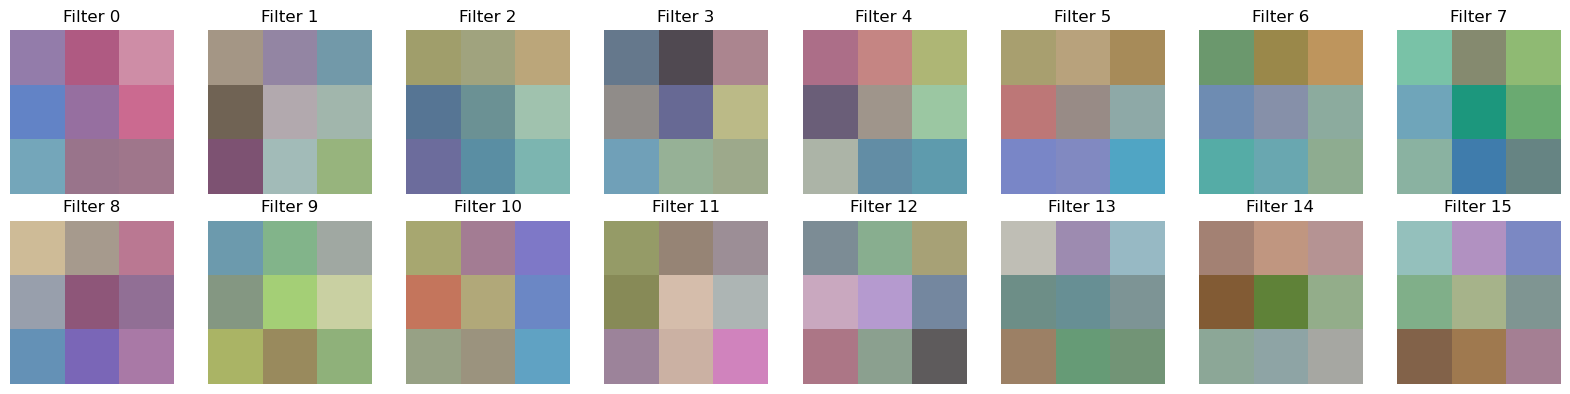

In [12]:
first_conv_layer = model.net[0]
visualize_filters(first_conv_layer, num_filters=16)

In [30]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

def show_feature_maps(feature_maps, layer_name="Layer", max_channels=8):
    feature_maps = feature_maps.detach().cpu()
    num_channels = min(feature_maps.shape[1], max_channels)

    cols = 4
    rows = (num_channels + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(num_channels):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_maps[0, i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Map {i}', fontsize=8)  # 控制字体避免重叠

    plt.suptitle(layer_name, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



In [29]:
def show_original_image(image_tensor, label=None):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # C,H,W → H,W,C
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image_np = std * image_np + mean  # 反标准化
    image_np = np.clip(image_np, 0, 1)
    
    plt.figure(figsize=(3, 3))
    plt.imshow(image_np)
    plt.axis('off')
    if label is not None:
        plt.title(f"Original Image (Label: {label})")
    else:
        plt.title("Original Image")
    plt.show()

In [31]:
def visualize_layers(model, image_tensor, label=None):
    show_original_image(image_tensor, label)
    
    x = image_tensor.unsqueeze(0)
    layers = model.net

    for idx, layer in enumerate(layers):
        x = layer(x)
        if isinstance(layer, (nn.Conv2d, Residual)):
            layer_type = layer.__class__.__name__
            show_feature_maps(x, layer_name=f'Layer {idx}: {layer_type}')


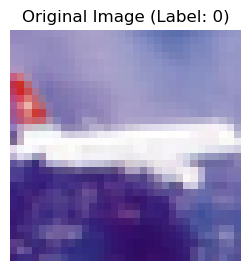

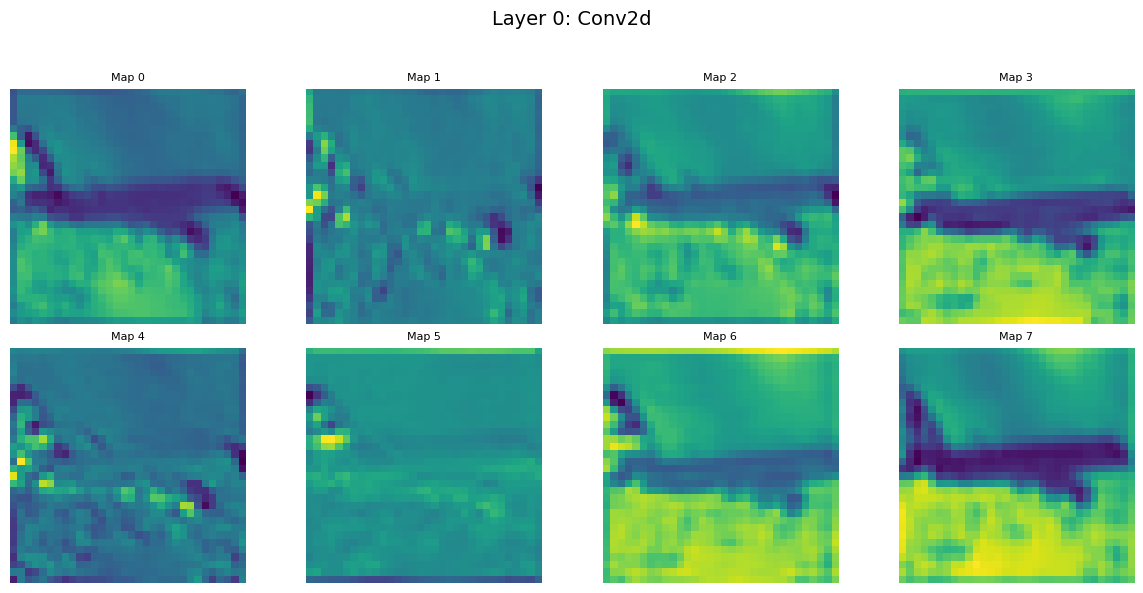

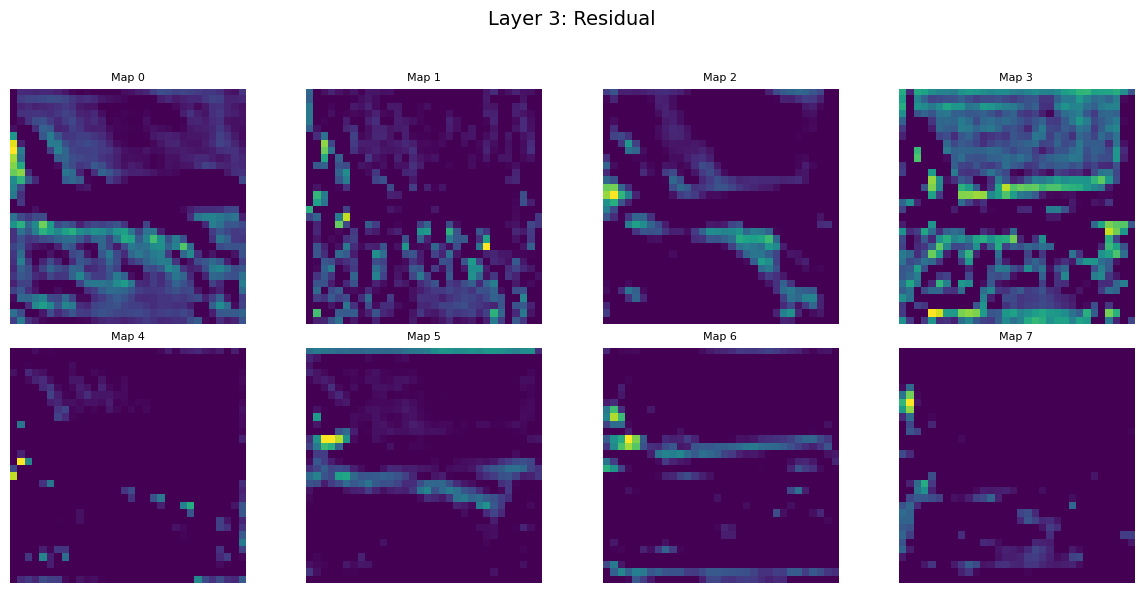

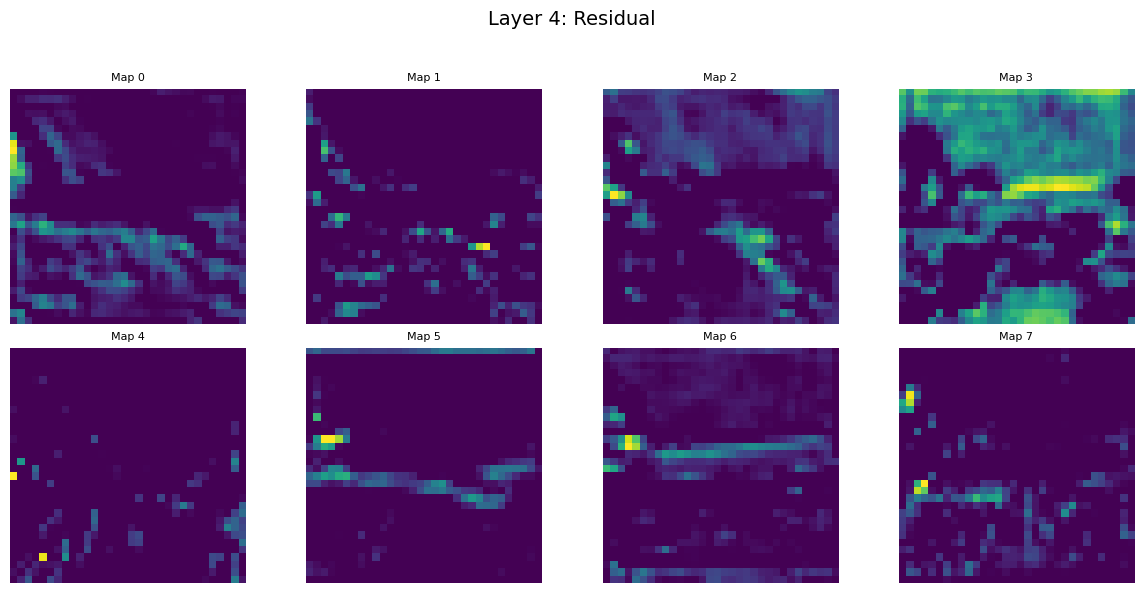

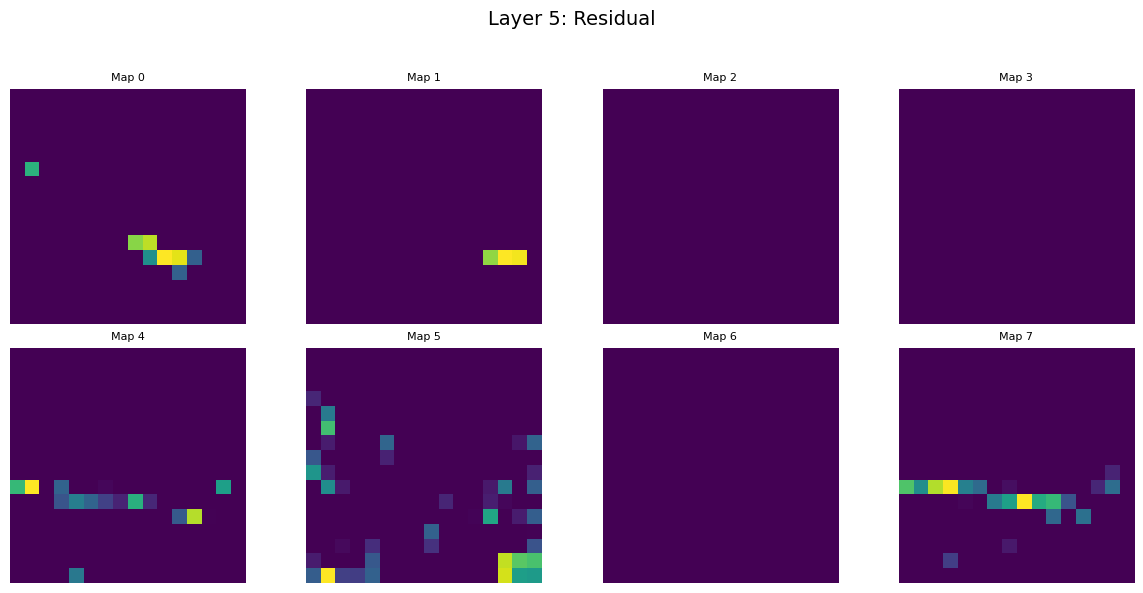

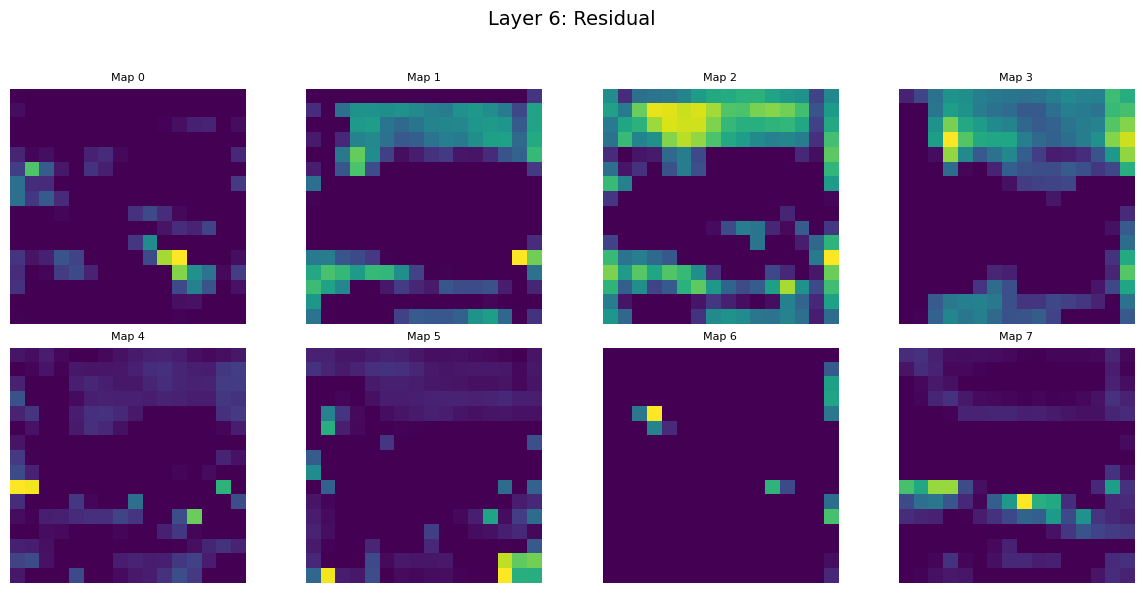

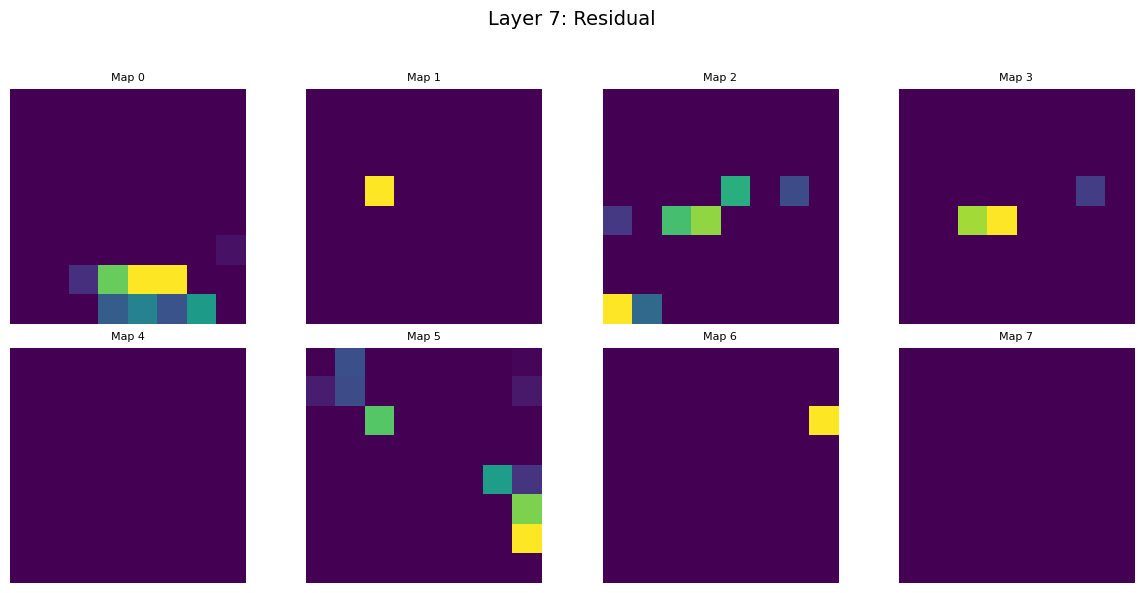

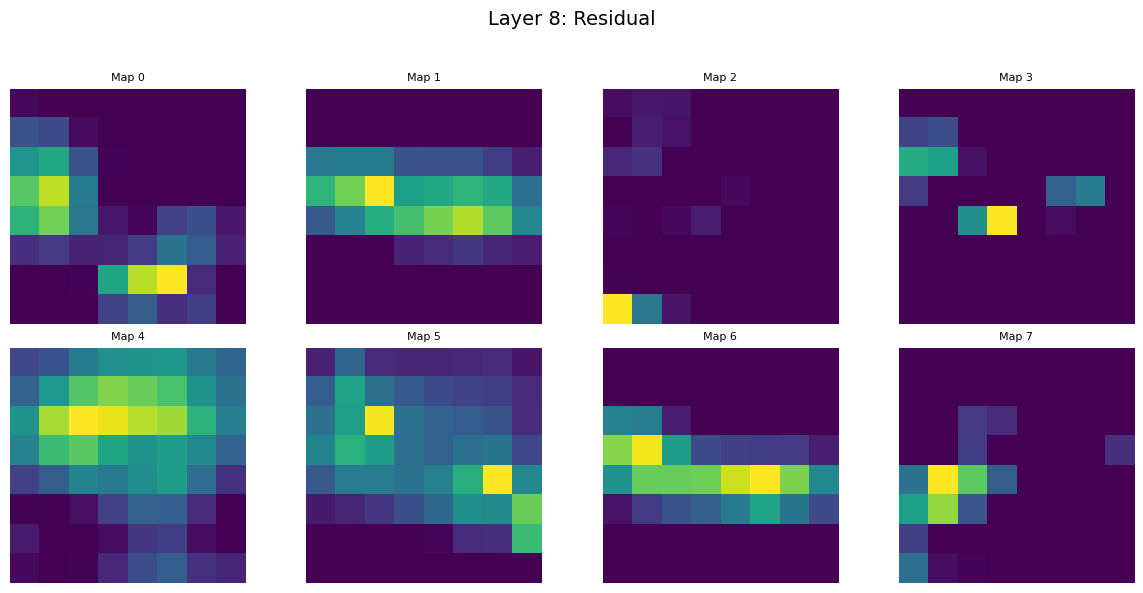

In [36]:
import random
data_iter = iter(test_loader)
rand_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[rand_index]
image=image.to(device)

model.eval()

# 可视化
visualize_layers(model, image,label)